<h1 style="text-align: center;">РАБОТА С ВРЕМЕННЫМИ РЯДАМИ В ЗАДАЧЕ ПРОГНОЗИРОВАНИЯ ЗАКАЗОВ ТАКСИ</h1>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Описание данных</a></span></li></ul></li><li><span><a href="#Импорт-библиотек-и-определение-констант" data-toc-modified-id="Импорт-библиотек-и-определение-констант-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт библиотек и определение констант</a></span></li><li><span><a href="#Обзор-и-подготовка-данных" data-toc-modified-id="Обзор-и-подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обзор и подготовка данных</a></span></li><li><span><a href="#Анализ-временного-ряда" data-toc-modified-id="Анализ-временного-ряда-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ временного ряда</a></span><ul class="toc-item"><li><span><a href="#Стационарность" data-toc-modified-id="Стационарность-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Стационарность</a></span></li><li><span><a href="#Тренд" data-toc-modified-id="Тренд-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Сезонность</a></span></li></ul></li><li><span><a href="#Конструирование-признаков" data-toc-modified-id="Конструирование-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Конструирование признаков</a></span></li><li><span><a href="#Формирование-выборок" data-toc-modified-id="Формирование-выборок-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Формирование выборок</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Моделирование</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов на следующий час.

### Постановка задачи
Постройте модель, которая спрогнозирует заказы такси на следующий час.
 
**Ход решения:**
 - загрузите и изучите данные, 
 - выполните ресемплирование данных по одному часу, 
 - проанализируйте данные, 
 - обучите разные модели с различными гиперпараметрами, 
 - проверьте лучшую модель на тестовой выборке и сделайте выводы.
 
**Примечания:**
 - определите размер тестовой выборки в 10% от исходных данных, 
 - для оценки качества моделей используйте метрику RMSE, 
 - значение RMSE на тестовой выборке должно быть не больше 48.

### Описание данных 
В вашем распоряжении исторические данные о заказах такси в аэропортах.
 
**Целевой признак:**
 - num_orders — количество заказов.
 
## Импорт библиотек и определение констант

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GridSearchCV,
)
from sklearn.metrics import mean_squared_error

In [2]:
#фиксируем:
# - путь к данным
PATH = '/datasets/taxi.csv'
# - целевой признак
TARGET = 'num_orders'
# - параметр random state
SEED = 3841

## Обзор и подготовка данных
Поместим данные в DataFrame, упорядочим их. На примере нескольких строк оценим датасет визульно. Посмотрим на общую информацию и описательную статистику.

In [3]:
df = pd.read_csv(PATH, index_col=[0], parse_dates=[0])
df = df.sort_index()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Типы данных, определены верно. Данные интерпретированы корректно. Пропуски отсутствуют. Описательная статистика количества заказов (`num_orders`) выглядит правдоподобно. Похоже, предобработка данных не требуется.

Присупим к анализу данных.
## Анализ временного ряда
Проверим данные на упорядоченность и оценим временной интервал. 

In [6]:
monotonic = lambda x: 'упорядочен' if x else 'НЕ упорядочен'
print(
    'Временной ряд', monotonic(df.index.is_monotonic),
    '\nГраницы ряда:',
    '\n - min', df.index.min(),
    '\n - max', df.index.max()    
)

Временной ряд упорядочен 
Границы ряда: 
 - min 2018-03-01 00:00:00 
 - max 2018-08-31 23:50:00


Ресемплируем данные с интервалом в 1 час, проверим результат.

In [7]:
df_h = df.resample('1H').sum()
df_h.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Преобразование прошло корректно.

### Стационарность
Определим скользящие среднее и стандарнтное отклонение, построим график временного ряда. 

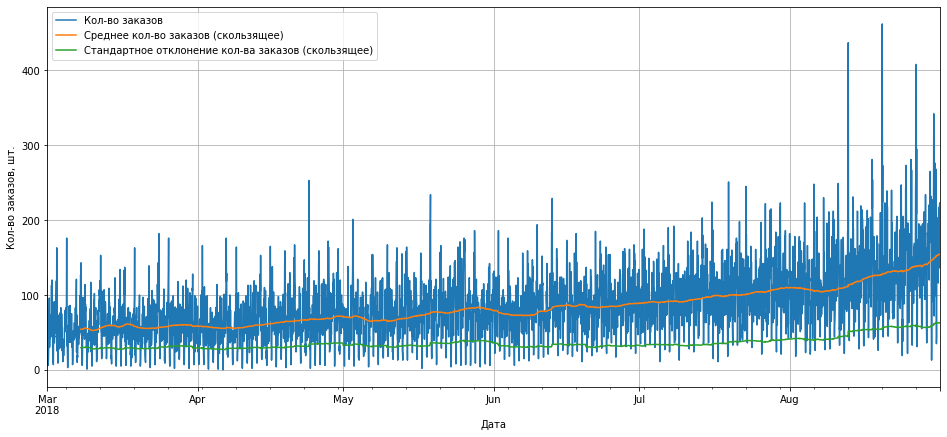

In [8]:
df_h_rolling = df_h[TARGET].rolling(168)
df_h['rolling_mean'] = df_h_rolling.mean()
df_h['rolling_std'] = df_h_rolling.std()
ax = df_h.plot(figsize=(16,7), grid=True)
ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во заказов, шт.')
ax.legend([
    'Кол-во заказов', 
    'Среднее кол-во заказов (скользящее)', 
    'Стандартное отклонение кол-ва заказов (скользящее)'
])
plt.show()

Временной ряд охватывает промежуток в полгода. Наблюдаем плавный рост среднего количества заказов и стандартного отклонения, следовательно, ряд не стационарен. 

Проведем декомпозицию: рассмотрим общий тренд и сезонность. 
### Тренд

In [9]:
df_h_decomposed = seasonal_decompose(df_h[TARGET])

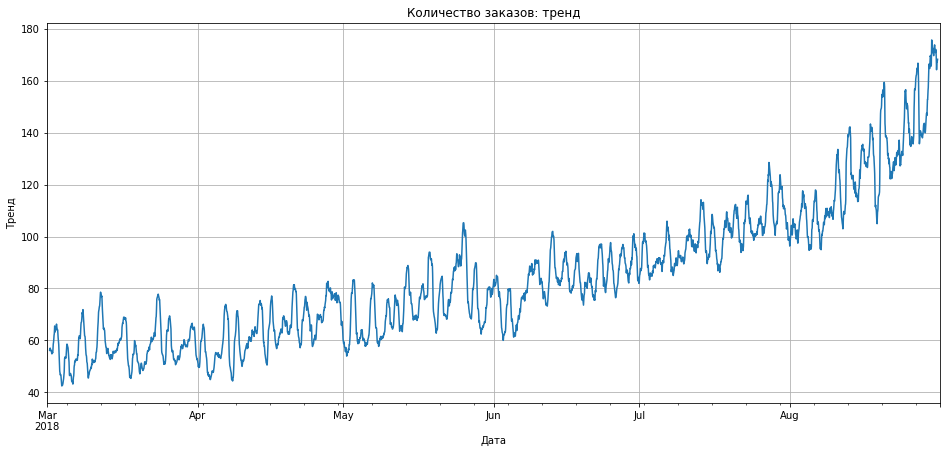

In [10]:
ax = df_h_decomposed.trend.plot(
    figsize=(16,7), 
    grid=True, 
    title='Количество заказов: тренд'
)
ax.set_xlabel('Дата')
ax.set_ylabel('Тренд')
plt.show()

Наблюдаем восходящий тренд: за полгода количество заказов выросло приблизительно в 2.5 раза. Следовательно, доля рынка компании увеличивается и/или услуги такси, в целом, становятся более популярны. 
### Сезонность
Справедливо предположить, что сезонность наблюдается в течение суток и недели. Для каждого месяца нашего ряда выберем случайные 3 дня и на их примере покажем сезонность заказов.

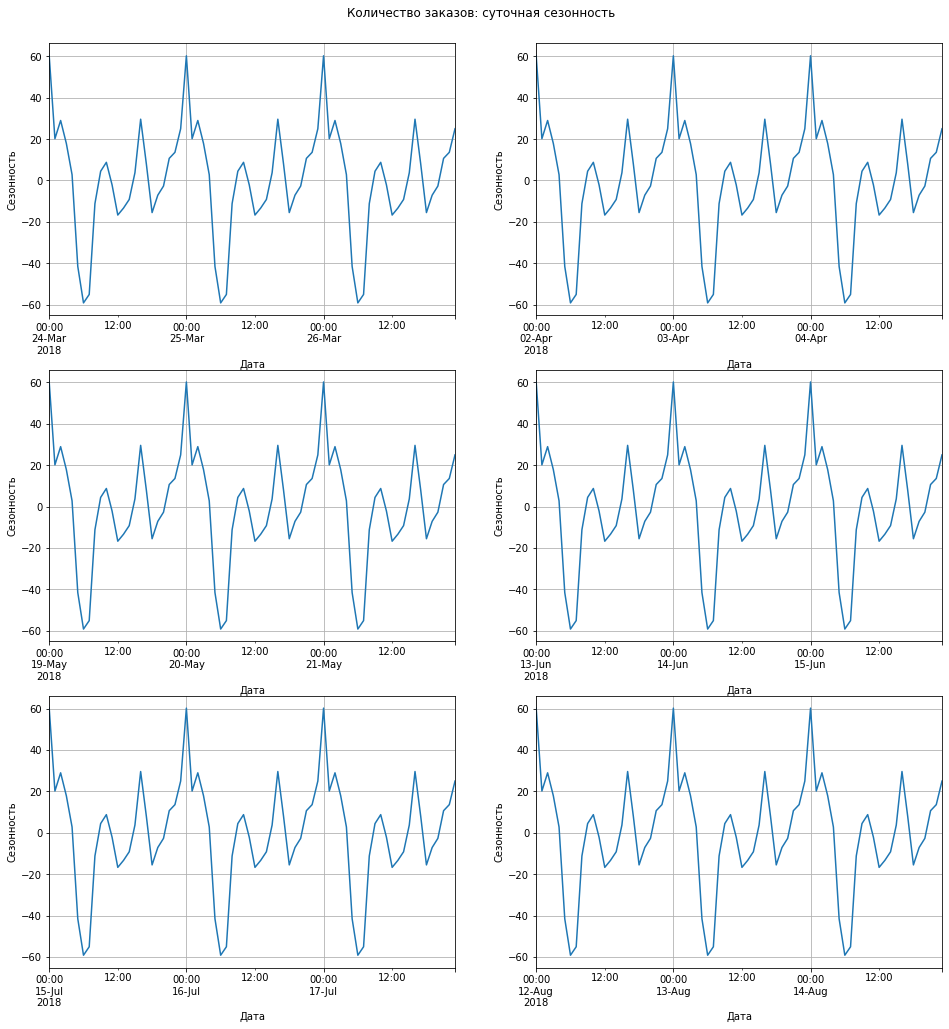

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(16, 17))    
month = 3
for row in range(0, ax.shape[0]):
    for col in range(0, ax.shape[1]):
        day_min = 0        
        while day_min < 1:
            day_max = np.random.randint(1, 31)
            day_min = day_max - 2
        date_max = '2018-{0}-{1}'.format(month, day_max)
        date_min = '2018-{0}-{1}'.format(month, day_min)
        df_h_decomposed.seasonal[date_min:date_max].plot(ax=ax[row][col])        
        ax[row][col].grid(True)
        ax[row][col].set_xlabel('Дата')
        ax[row][col].set_ylabel('Сезонность')
        month += 1
fig.suptitle('Количество заказов: суточная сезонность', y=0.91)
fig.show()

Наблюдаем цикл, общий для всего ряда: 
 - на 00:00 приходится максимальное количество заказов,
 - с 00:00 до 06:00 количество заказов постепенно снижается до минимума, 
 - с 06:00 до 12:00 и с 12:00 до 18:00 - два локальных всплеска заказов,
 - с 18:00 до 00:00 количество заказов постепенно возрастает до максимума.
 
Рассмотрим недельную сезонность. Для этого ресемплируем временной ряд с периодом в 1 день и добавим признак недели. Для каждого месяца нашего ряда выберем случайный 3х недельный отрезок и на его примере построим графики сезонности.

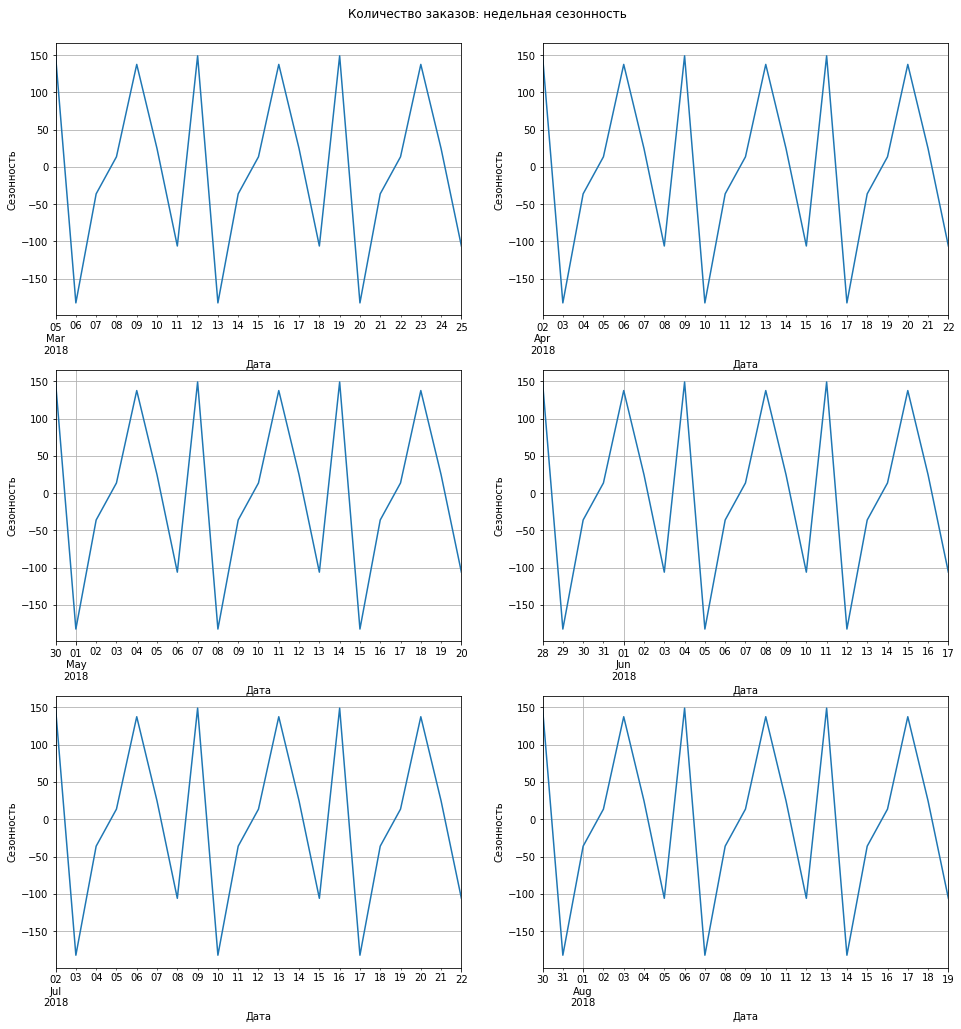

In [12]:
df_d = df.resample('1D').sum()
df_d['week'] = pd.Int64Index(df_d.index.isocalendar().week)
df_d_decomposed = seasonal_decompose(df_d[TARGET])

fig, ax = plt.subplots(3, 2, figsize=(16, 17))
month = 3
for row in range(0, ax.shape[0]):
    for col in range(0, ax.shape[1]):
        week_range = (
            df_d.loc['2018-{0}'.format(month)]['week'].min(), 
            df_d.loc['2018-{0}'.format(month)]['week'].max()
        ) 
        week_min = -1        
        while week_min < week_range[0]:
            week_max = np.random.randint(week_range[0], week_range[1])
            week_min = week_max - 2 
        weeks = list(range(week_min, week_max + 1))
        idx = df_d[df_d['week'].isin(weeks)].index
        df_d_decomposed.seasonal[idx].plot(ax=ax[row][col])        
        ax[row][col].grid(True)
        ax[row][col].set_xlabel('Дата')
        ax[row][col].set_ylabel('Сезонность')
        month += 1
fig.suptitle('Количество заказов: недельная сезонность', y=0.91)
fig.show()

Недельная сезонность налицо: 
 - на пнд приходится максимальное количество заказов,
 - во вт число заказов резко падает до минимума, 
 - со вт до пнт заказы постепенно растут почти до максимума
 - с пнт до вскр количество заказов постепенно падает.

## Конструирование признаков 
Учтем нестационарность нашего временного ряда. Сконструируем на его основе новое признаковое пространство, тем самым повысив качество прогноза. Перечислим новые признаки: 
 - месяц (`month`), 
 - день месяца (`day`), 
 - неделя (`week`), 
 - день недели (`dayofweek`),
 - час (`hour`),
 - отстающие значения (`lag_i`), 
 - скользящее среднее (`rolling_mean`).
 
Опишем функцию, создающую новые признаки.

In [13]:
def make_features(data, max_lag, window_size):
    """Возвращает копию оригинального 
    временного ряда с новыми признаками.
    АРГУМЕНТЫ:
    data -- оригинальный временной ряд,
    max_lag -- количество признаков "отстающих" значений
    window_size -- размер окна для скользящего среднего
    """
    #создаем новый временной ряд
    data = data.copy()
    #добавляем к новому временному ряду:
    # - календарные признаки 
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['week'] = pd.Int64Index(data.index.isocalendar().week)
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # - признаки "отстающих" значений
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[TARGET].shift(lag)
    # - скользящее среднее
    data['rolling_mean'] = data[TARGET].rolling(window_size, closed='left').mean()
    #возвращаем временной ряд с новыми признаками
    return data

Добавим новые признаки в датасет, удалим образовавшиеся пропуски и посмотрим на результат.

In [14]:
data = make_features(df.resample('1H').sum(), 12, 24)
data = data.dropna()
data.head(10)

,num_orders,month,day,week,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,9,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,56.833333
2018-03-02 01:00:00,120,3,2,9,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,55.416667
2018-03-02 02:00:00,75,3,2,9,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,56.875000
2018-03-02 03:00:00,64,3,2,9,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,3,2,9,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,56.958333
2018-03-02 05:00:00,11,3,2,9,4,5,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,56.000000
2018-03-02 06:00:00,11,3,2,9,4,6,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,56.208333
2018-03-02 07:00:00,7,3,2,9,4,7,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,56.166667
2018-03-02 08:00:00,46,3,2,9,4,8,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,55.833333


Преобразования прошли корректно.
## Формирование выборок
Сформируем обучающую и тестовую выборки. Проверим результат.

In [15]:
X = data.drop(TARGET, axis=1)
y = data[TARGET]

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.1, shuffle=False)

print('Размер выборок:',
     '\n - обучающая (признаки):', X_train.shape,
     '\n - обучающая (целевой признак):', y_train.shape,
     '\n - тестовая (признаки):', X_test.shape,
     '\n - тестовая (целевой признак):', y_test.shape)

Размер выборок: 
 - обучающая (признаки): (3952, 18) 
 - обучающая (целевой признак): (3952,) 
 - тестовая (признаки): (440, 18) 
 - тестовая (целевой признак): (440,)


Выборки сформированы корректно.

## Моделирование
Перед нами стоит задача прогнозирования временного ряда. Решим ее с помощью LGBMRegressor, CatBoostRegressor, а так же RandomForestRegressor. 

**Ход исследования:**
 - на обучающей выборке, с применением кроссвалидации и метрики RMSE, для каждой модели подберем гиперпараметры, 
 - на тестовой выборке, для каждой модели определим RMSE,
 - сравним модели, сформулируем выводы.

Опишем помогающую функцию.

In [16]:
def print_result(search):
    """
    Выводит на экран наименование, значение метрики 
    и гиперпараметры для лучшей модели кросс-валидатора.
    АРГУМЕНТЫ:
    search -- кросс-валидатор
    """
    print(
        'Валидационная выборка:', 
        '\n - модель', search.best_estimator_.__class__.__name__, 
        '\n - лучшая RMSE', round(-1 * search.best_score_, 3), 
        '\n - лучшие гиперпараметры', search.best_params_
    )

### RandomForestRegressor

In [17]:
rfr = RandomForestRegressor(random_state=SEED)
#готовим гиперпараметры
params_rfr = {    
    'n_estimators' : [50, 100, 200]
}
#готовим подбор гиперпараметров с кроссвалидацией
search_rfr = GridSearchCV(
    rfr,
    param_grid = params_rfr,     
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(),
    verbose=False
)

In [18]:
search_rfr.fit(X_train, y_train)
print_result(search_rfr)

Валидационная выборка: 
 - модель RandomForestRegressor 
 - лучшая RMSE 24.603 
 - лучшие гиперпараметры {'n_estimators': 200}


### CatBoostRegressor

In [19]:
cbr = CatBoostRegressor(random_state=SEED, verbose=False)
#готовим гиперпараметры
params_cbr = {    
    'iterations' : [50, 100, 200],      
    'learning_rate' : [0.4, 0.5, 0.6]
}
#готовим подбор гиперпараметров с кроссвалидацией
search_cbr = GridSearchCV(
    cbr, 
    param_grid=params_cbr,
    scoring='neg_root_mean_squared_error',
    cv=TimeSeriesSplit(),
    verbose=False  
)

In [20]:
search_cbr.fit(X_train, y_train)
print_result(search_cbr)

Валидационная выборка: 
 - модель CatBoostRegressor 
 - лучшая RMSE 25.57 
 - лучшие гиперпараметры {'iterations': 50, 'learning_rate': 0.4}


### LGBMRegressor

In [21]:
lgbmr = lgb.LGBMRegressor(random_state=SEED, verbose=-1)
#готовим гиперпараметры
params_lgbmr = {    
    'num_iterations' : [50, 100, 200],
    'learning_rate' : [0.4, 0.5, 0.6]          
} 
#готовим подбор гиперпараметров с кроссвалидацией
search_lgbmr = GridSearchCV(
    lgbmr, 
    param_grid=params_lgbmr, 
    scoring='neg_root_mean_squared_error', 
    cv=TimeSeriesSplit(),
    verbose=False, 
    n_jobs=4
)

In [22]:
search_lgbmr.fit(X_train, y_train)
print_result(search_lgbmr)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

Валидационная выборка: 
 - модель LGBMRegressor 
 - лучшая RMSE 26.375 
 - лучшие гиперпараметры {'learning_rate': 0.4, 'num_iterations': 50}


### Сравнение моделей
Рассмотрим общую таблицу результатов.

In [29]:
searches = [
    search_rfr, 
    search_cbr,
    search_lgbmr
]
results = {}
rmse_test = []
#для каждого кросс-валидатора...
for search in searches:
    #сохраняем лучший результат 
    estimator = search.best_estimator_.__class__.__name__
    score = -1 * search.best_score_
    results[estimator] = [score]    
#сводим таблицу результатов
pd.DataFrame(results, index=['RMSE_valid'])

,RandomForestRegressor,CatBoostRegressor,LGBMRegressor
RMSE_valid,24.602538,25.569797,26.374832


Зафиксируем наблюдения:
 - все модели показывают весьма близкую точность (RMSE) на обучающей выборке;
 - лучшая модель по критерию RMSE - RandomForestRegressor. 

Определим RMSE для лучшей модели на тестовой выборке.

In [28]:
y_predicted = search_rfr.predict(X_test)
rmse_test = mean_squared_error(y_test, y_predicted, squared=False)
print(
    'Тестовая выборка:',
    '\n - модель', search_rfr.best_estimator_.__class__.__name__, 
    '\n - RMSE', round(rmse_test, 3), 
    '\n - гиперпараметры', search_rfr.best_params_
)        

Тестовая выборка: 
 - модель RandomForestRegressor 
 - RMSE 43.309 
 - гиперпараметры {'n_estimators': 200}


Получили точность, удовлетворяющую условиям задачи (менее 48 заказов). Визуализируем реальное и предсказанное количество заказов.

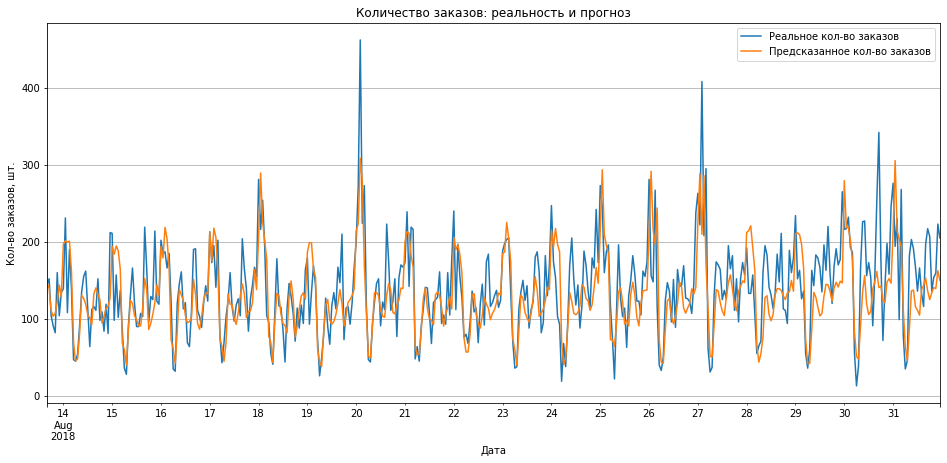

In [43]:
y_predicted = pd.Series(y_predicted, index=y_test.index)
ax = pd.concat([y_test, y_predicted], axis=1).plot(
    figsize=(16, 7), 
    grid=True,
    title='Количество заказов: реальность и прогноз' 
)
ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во заказов, шт.')
ax.legend([
    'Реальное кол-во заказов', 
    'Предсказанное кол-во заказов'
])
plt.show()

## Выводы
**В ходе обзора и подготовки данных** было показано, что предобработка не требуется ([см.3](#%D0%9E%D0%B1%D0%B7%D0%BE%D1%80-%D0%B8-%D0%BF%D0%BE%D0%B4%D0%B3%D0%BE%D1%82%D0%BE%D0%B2%D0%BA%D0%B0-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)). 

**В ходе анализа показано, что временной ряд:** 
 - не стационарен ([см.4.1](#%D0%A1%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C)), 
 - демонстрирует восходящий тренд ([см.4.2](#%D0%A2%D1%80%D0%B5%D0%BD%D0%B4)), 
 - имеет дневную и недельную сезонность ([см.4.3](#%D0%A1%D0%B5%D0%B7%D0%BE%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D1%8C)).

**Конструированием новых признаков** компенсирована нестационарность временного ряда ([см.5](#%D0%9A%D0%BE%D0%BD%D1%81%D1%82%D1%80%D1%83%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2)).

**В ходе моделирования:** 
 - на обучающей выборке проведен поиск гиперпараметров с кроссвалидацией и метрикой RMSE для моделей:
     - RandomForestRegressor ([см.7.1](#RandomForestRegressor)),
     - CatBoostRegressor ([см.7.2](#CatBoostRegressor)),
     - LGBMRegressor ([см.7.3](#LGBMRegressor)),
 - показано, что RandomForestRegressor:
     - является лучшей моделью по критерию RMSE на обучающей выборке,
     - имеет RMSE ниже контрольного значения в 48 заказов на тестовой выборке ([см.7.4](#%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9)).